# Build models for prediction

## This notebook is the same as previous but includes MONTH, DAY, WEEK as features.

### Uses new data files from 20210608

* Template_905.xlsx          
* validation905.xlsx
* training905.xlsx



In a *regression* problem, we try to predict the output of a continuous value, like a price or a probability. 

This notebook uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
pip install pandas

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.0


Prep GPU

In [5]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## The training dataset

File: PO4_Training.xlsx

In [7]:
pip install openpyxl

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
data = pd.read_excel("training905.xlsx",na_values="NaN",  engine='openpyxl')

Take a look.

In [10]:
data.head()

,datetime,Year,Time,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
0,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,10.000,7.870,1882.000,27.000,8.900,21.300,0.810,0.310
1,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.759,7.842,1901.641,26.753,9.174,21.555,0.799,0.289
2,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.816,7.858,1923.555,26.720,9.551,21.220,0.595,0.275
3,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.806,7.856,1837.397,26.445,8.348,21.830,0.916,0.362
4,2016-01-01 00:15:00,2016,00:15:00,1,1,1,2.337,10.000,7.860,1885.000,27.000,9.000,21.300,0.810,0.310


In [11]:
data.tail()

,datetime,Year,Time,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
433327,2020-12-31 23:30:00,2020,23:30:00,12,31,5,1.815,7.747,8.394,699.830,NaN,12.233,13.181,-0.072,0.123
433328,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.600,8.340,715.000,NaN,12.200,13.400,0.160,0.180
433329,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.701,8.338,695.460,NaN,11.723,13.465,0.108,0.205
433330,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,8.070,8.304,681.666,NaN,12.485,12.408,-0.058,0.244
433331,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.495,8.356,756.958,NaN,11.342,13.893,0.065,0.165


In [12]:
data.columns

Index(['datetime', 'Year', 'Time', 'Month', 'Day', 'Week', 'GHI', 'TEMP', 'PH',
       'EC', 'TURB', 'SA DO', 'SA NO3', 'SA NH4', 'SA PO4'],
      dtype='object')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433332 entries, 0 to 433331
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  433332 non-null  datetime64[ns]
 1   Year      433332 non-null  int64         
 2   Time      433332 non-null  object        
 3   Month     433332 non-null  int64         
 4   Day       433332 non-null  int64         
 5   Week      433332 non-null  int64         
 6   GHI       433332 non-null  float64       
 7   TEMP      433332 non-null  float64       
 8   PH        433332 non-null  float64       
 9   EC        433332 non-null  float64       
 10  TURB      409652 non-null  float64       
 11  SA DO     433332 non-null  float64       
 12  SA NO3    433332 non-null  float64       
 13  SA NH4    433332 non-null  float64       
 14  SA PO4    433332 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(4), object(1)
memory usage: 49.6+ MB


### Clean the data

How many NaNs??

In [13]:
data.isna().sum()

datetime        0
Year            0
Time            0
Month           0
Day             0
Week            0
GHI             0
TEMP            0
PH              0
EC              0
TURB        23680
SA DO           0
SA NO3          0
SA NH4          0
SA PO4          0
dtype: int64

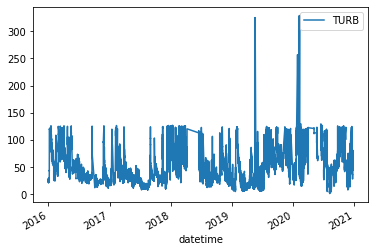

In [15]:
data.plot(x='datetime', y="TURB");

For now, we impute the mean for any missing values.

In [16]:
data = data.fillna(data.mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [17]:
data.isna().sum()

datetime    0
Year        0
Time        0
Month       0
Day         0
Week        0
GHI         0
TEMP        0
PH          0
EC          0
TURB        0
SA DO       0
SA NO3      0
SA NH4      0
SA PO4      0
dtype: int64

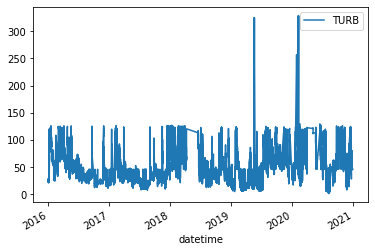

In [18]:
data.plot(x='datetime', y="TURB");

In [19]:
data.tail()

,datetime,Year,Time,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
433327,2020-12-31 23:30:00,2020,23:30:00,12,31,5,1.815,7.747,8.394,699.830,45.961843,12.233,13.181,-0.072,0.123
433328,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.600,8.340,715.000,45.961843,12.200,13.400,0.160,0.180
433329,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.701,8.338,695.460,45.961843,11.723,13.465,0.108,0.205
433330,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,8.070,8.304,681.666,45.961843,12.485,12.408,-0.058,0.244
433331,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.495,8.356,756.958,45.961843,11.342,13.893,0.065,0.165


### Split the data into train and test

Now split the dataset into a training set and a test set.  Note use of sample.  That grabs a random selection of data of the desired size.

We will use the test set in the final evaluation of our models.



In [20]:
train_data = data.sample(frac=0.9, random_state=0)
test_data = data.drop(train_data.index)

In [21]:
len(train_data)

389999

In [22]:
len(test_data)

43333

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.  One target and five features.  It's looking like there are some outliers in PH.


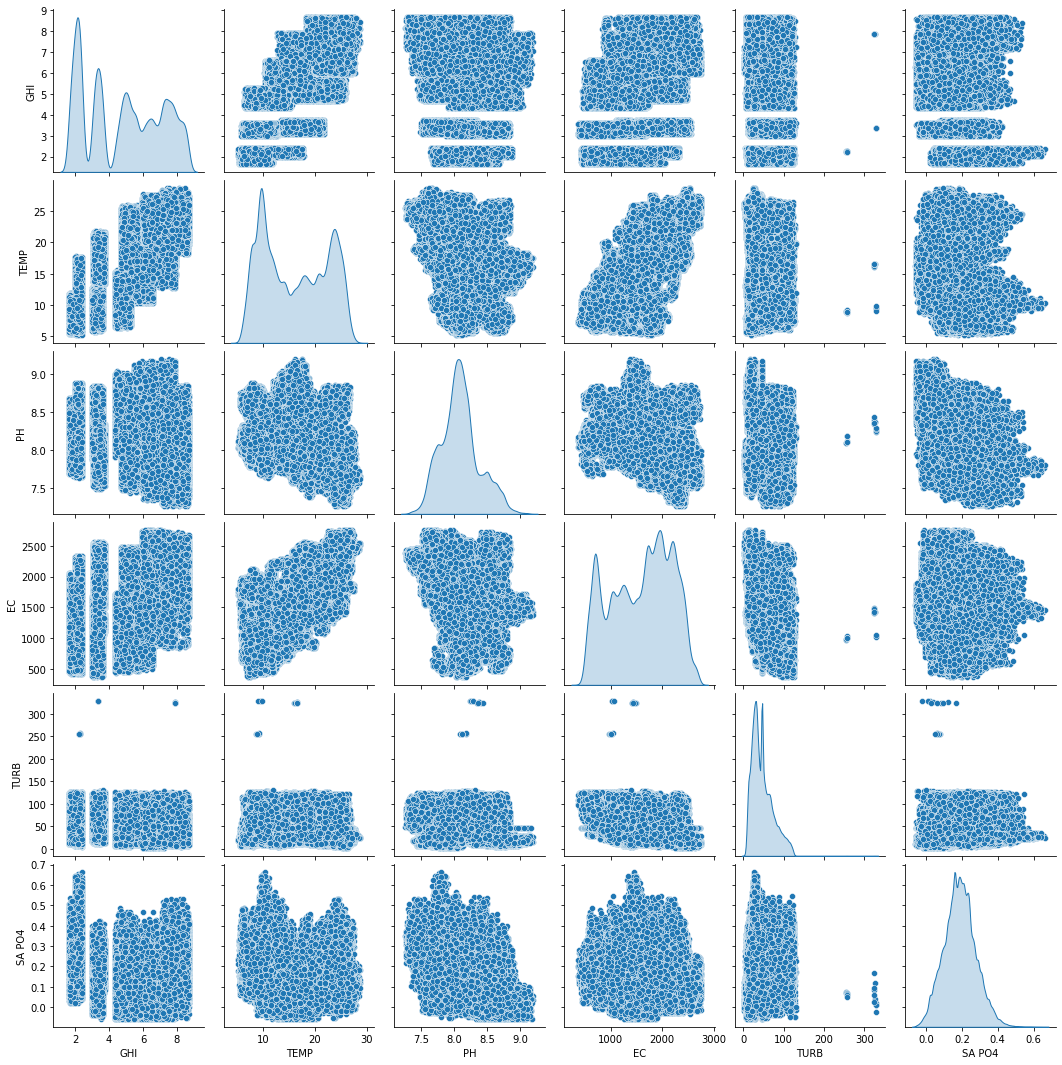

In [23]:
sns.pairplot(train_data[["GHI","TEMP","PH","EC","TURB", 'SA PO4']], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [25]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,389999.0,2017.800035,1.354273,2016.000,2017.000,2018.000,2019.0000,2020.000
Month,389999.0,6.542648,3.512460,1.000,3.000,7.000,10.0000,12.000
Day,389999.0,15.617479,8.850489,1.000,8.000,16.000,23.0000,31.000
Week,389999.0,2.686563,1.279137,1.000,2.000,3.000,4.0000,5.000
GHI,389999.0,4.797451,2.206960,1.620,2.387,4.872,6.8390,8.690
TEMP,389999.0,16.067202,6.217601,5.132,10.099,15.700,22.2000,28.733
PH,389999.0,8.084271,0.292527,7.255,7.895,8.067,8.2340,9.200
EC,389999.0,1590.915175,580.889936,363.915,1097.687,1688.593,2071.0640,2759.993
TURB,389999.0,45.990564,25.651363,1.306,26.796,40.543,60.9565,328.799
SA DO,389999.0,7.659964,2.404185,0.218,5.837,7.700,9.5460,14.384


### Split features from targets

Separate the target values from the features.  

As a first cut, I'm going to leave out month, day and week because of inconsistencies between the files that I downloaded from Vishy.

Also, I'll just do one target (PO4) to get on the air.

'datetime', 'Year', 'Time', 'Month', 'Day', 'Week', 'GHI', 'TEMP', 'PH',
       'EC', 'TURB', 'SA DO', 'SA NO3', 'SA NH4', 'SA PO4']

In [26]:
train_features = train_data[['Month', 'Day', 'Week', 'GHI', 'TEMP', 'PH', 'EC', 'TURB']]
test_features = test_data[['Month', 'Day', 'Week', 'GHI', 'TEMP', 'PH', 'EC', 'TURB']]

In [28]:
train_target = train_data[['SA PO4']]
test_target = test_data[['SA PO4']]

In [29]:
train_features.head()

,Month,Day,Week,GHI,TEMP,PH,EC,TURB
121339,4,12,2,5.459,17.320,7.894,1340.190,45.961843
288783,1,15,3,2.237,8.040,8.712,1853.642,21.243000
101841,2,5,1,3.112,9.368,8.154,1060.954,113.972000
285799,1,7,1,2.201,6.825,8.559,1820.651,22.572000
380441,2,13,2,3.629,11.660,8.271,1142.789,36.890000


In [31]:
test_features.head()

,Month,Day,Week,GHI,TEMP,PH,EC,TURB
21,1,1,1,1.987,9.766,7.848,1907.415,27.995
27,1,1,1,2.099,9.803,7.842,1849.197,26.633
43,1,1,1,2.024,10.438,7.854,1892.609,28.255
46,1,1,1,2.155,9.697,7.864,1851.037,27.491
92,1,1,1,2.275,10.000,7.830,1899.000,27.000


In [33]:
train_target.head()

,SA PO4
121339,0.217
288783,0.115
101841,0.269
285799,0.233
380441,0.014


In [34]:
test_target.head()

,SA PO4
21,0.274
27,0.212
43,0.216
46,0.330
92,0.260


## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [36]:
train_data.describe().transpose()[['50%', 'mean', 'std' ]]

,50%,mean,std
Year,2018.000,2017.800035,1.354273
Month,7.000,6.542648,3.512460
Day,16.000,15.617479,8.850489
Week,3.000,2.686563,1.279137
GHI,4.872,4.797451,2.206960
TEMP,15.700,16.067202,6.217601
PH,8.067,8.084271,0.292527
EC,1688.593,1590.915175,580.889936
TURB,40.543,45.990564,25.651363
SA DO,7.700,7.659964,2.404185


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable. 

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [37]:
normalizer = preprocessing.Normalization()

Then `.adapt()` it to the data:

In [38]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [39]:
print(normalizer.mean.numpy())

[   6.543   15.617    2.687    4.797   16.067    8.084 1590.915   45.991]


When the layer is called it returns the input data, with each feature independently normalized:

In [40]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.     12.      2.      5.46   17.32    7.89 1340.19   45.96]]

Normalized: [[-0.72 -0.41 -0.54  0.3   0.2  -0.65 -0.43 -0.  ]]


## Linear regression

Before building a DNN model, start with a linear regression.

### One Variable

Start with a single-variable linear regression, to predict `PO4` from `TEMP`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case we use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

* Normalize the input `TEMP`.
* Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the temp `Normalization` layer:

In [41]:
temp = np.array(train_features['TEMP'])

temp_normalizer = preprocessing.Normalization(input_shape=[1,])
temp_normalizer.adapt(temp)

Build the sequential model:

In [42]:
temp_model = tf.keras.Sequential([
    temp_normalizer,
    layers.Dense(units=1)
])

temp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `PO4` from `TEMP`.

Run the untrained model on the first 10 temp values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [43]:
temp_model.predict(temp[:10])

array([[ 0.094],
       [-0.601],
       [-0.502],
       [-0.692],
       [-0.33 ],
       [ 0.654],
       [-0.494],
       [-0.042],
       [-0.443],
       [-0.544]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [44]:
temp_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Once the training is configured, use `Model.fit()` to execute the training:

In [45]:
%%time
history = temp_model.fit(
    train_features['TEMP'], train_target,
    epochs=10,
    # don't suppress logging
    verbose=1,
    # Calculate validation results on 10% of the training data
    validation_split = 0.1)

Epoch 1/10
10969/10969 [==============================] - 10s 870us/step - loss: 0.0759 - val_loss: 0.0741
Epoch 2/10
10969/10969 [==============================] - 9s 840us/step - loss: 0.0748 - val_loss: 0.0764
Epoch 3/10
10969/10969 [==============================] - 9s 844us/step - loss: 0.0751 - val_loss: 0.0808
Epoch 4/10
10969/10969 [==============================] - 9s 851us/step - loss: 0.0747 - val_loss: 0.0702
Epoch 5/10
10969/10969 [==============================] - 9s 843us/step - loss: 0.0750 - val_loss: 0.0700
Epoch 6/10
10969/10969 [==============================] - 9s 850us/step - loss: 0.0755 - val_loss: 0.0802
Epoch 7/10
10969/10969 [==============================] - 9s 860us/step - loss: 0.0748 - val_loss: 0.0718
Epoch 8/10
10969/10969 [==============================] - 9s 845us/step - loss: 0.0752 - val_loss: 0.0704
Epoch 9/10
10969/10969 [==============================] - 9s 851us/step - loss: 0.0751 - val_loss: 0.0703
Epoch 10/10
10969/10969 [====================

Visualize the model's training progress using the stats stored in the `history` object.

In [46]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
5,0.075207,0.080198,5
6,0.074989,0.071786,6
7,0.075226,0.070361,7
8,0.074972,0.070287,8
9,0.075146,0.074708,9


In [47]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [PO4]')
  plt.legend()
  plt.grid(True)

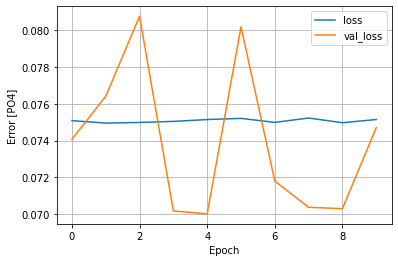

In [48]:
plot_loss(history)

Collect the results on the test set, for later:

In [49]:
test_results = {}

test_results['temp_model'] = temp_model.evaluate(
    test_features['TEMP'],
    test_target, verbose=0)

SInce this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [50]:
x = tf.linspace(5.0, 30, 251)
y = temp_model.predict(x)

In [51]:
def plot_temp(x, y):
  plt.scatter(train_features['TEMP'], train_target, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Temp')
  plt.ylabel('PO3')
  plt.legend()

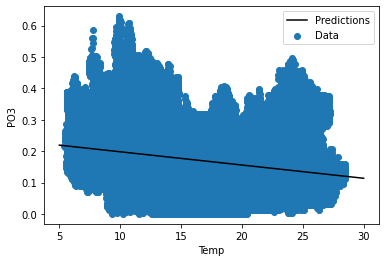

In [42]:
plot_temp(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [52]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [53]:
linear_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8)                 17        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 26
Trainable params: 9
Non-trainable params: 17
_________________________________________________________________


When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [54]:
linear_model.predict(train_features[:10])

array([[-0.019],
       [-0.946],
       [ 0.414],
       [-1.87 ],
       [-0.203],
       [-0.945],
       [-0.713],
       [ 1.925],
       [-1.931],
       [ 1.26 ]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(9,1)`.

In [55]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(8, 1) dtype=float32, numpy=
array([[-0.104],
       [ 0.578],
       [ 0.24 ],
       [-0.206],
       [ 0.493],
       [-0.029],
       [-0.499],
       [ 0.459]], dtype=float32)>

Use the same `compile` and `fit` calls as for the single input `TEMP` model:

In [56]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [57]:
%%time
history = linear_model.fit(
    train_features, train_target, 
    epochs=20,
    # don't suppress logging
    verbose=1,
    # Calculate validation results on 10% of the training data
    validation_split = 0.1)

Epoch 1/20
10969/10969 [==============================] - 9s 839us/step - loss: 0.0946 - val_loss: 0.1032
Epoch 2/20
10969/10969 [==============================] - 9s 828us/step - loss: 0.0899 - val_loss: 0.1150
Epoch 3/20
10969/10969 [==============================] - 9s 834us/step - loss: 0.0905 - val_loss: 0.0916
Epoch 4/20
10969/10969 [==============================] - 10s 886us/step - loss: 0.0908 - val_loss: 0.0827
Epoch 5/20
10969/10969 [==============================] - 9s 839us/step - loss: 0.0903 - val_loss: 0.0910
Epoch 6/20
10969/10969 [==============================] - 9s 844us/step - loss: 0.0908 - val_loss: 0.0781
Epoch 7/20
10969/10969 [==============================] - 9s 844us/step - loss: 0.0901 - val_loss: 0.0771
Epoch 8/20
10969/10969 [==============================] - 9s 845us/step - loss: 0.0898 - val_loss: 0.0821
Epoch 9/20
10969/10969 [==============================] - 9s 846us/step - loss: 0.0903 - val_loss: 0.0795
Epoch 10/20
10969/10969 [====================

Using all the inputs does not improve training and validation error than the `TEMP` model: 

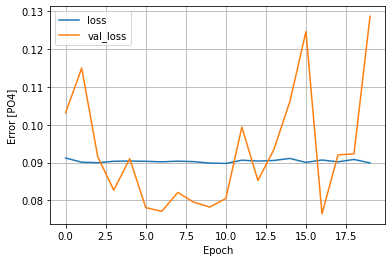

In [58]:
plot_loss(history)

Collect the results on the test set, for later:

In [59]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_target, verbose=0)

In [60]:
test_results

{'temp_model': 0.07481340318918228, 'linear_model': 0.12832607328891754}

## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [61]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### One variable

Start with a DNN model for a single input: "TEMP"

In [62]:
dnn_temp_model = build_and_compile_model(temp_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [63]:
dnn_temp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model:

In [64]:
%%time
history = dnn_temp_model.fit(
    train_features['TEMP'], train_target,
    validation_split=0.1,
    verbose=1, epochs=20)

Epoch 1/20
10969/10969 [==============================] - 11s 990us/step - loss: 0.0695 - val_loss: 0.0680
Epoch 2/20
10969/10969 [==============================] - 11s 978us/step - loss: 0.0676 - val_loss: 0.0670
Epoch 3/20
10969/10969 [==============================] - 10s 956us/step - loss: 0.0674 - val_loss: 0.0670
Epoch 4/20
10969/10969 [==============================] - 11s 967us/step - loss: 0.0674 - val_loss: 0.0670
Epoch 5/20
10969/10969 [==============================] - 11s 982us/step - loss: 0.0674 - val_loss: 0.0669
Epoch 6/20
10969/10969 [==============================] - 11s 961us/step - loss: 0.0672 - val_loss: 0.0671
Epoch 7/20
10969/10969 [==============================] - 11s 970us/step - loss: 0.0674 - val_loss: 0.0670
Epoch 8/20
10969/10969 [==============================] - 11s 969us/step - loss: 0.0674 - val_loss: 0.0669
Epoch 9/20
10969/10969 [==============================] - 11s 981us/step - loss: 0.0674 - val_loss: 0.0669
Epoch 10/20
10969/10969 [============

This model does slightly better than the linear-temp model but is much more stable.

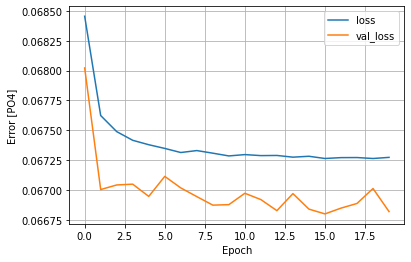

In [65]:
plot_loss(history)

If you plot the predictions as a function of `temp`, you'll see how this model takes advantage of the nonlinearity provided by the hidden layers:

In [66]:
x = tf.linspace(5.0, 30, 251)
y = dnn_temp_model.predict(x)

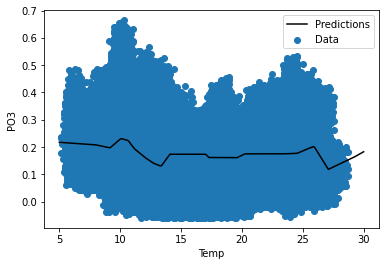

In [67]:
plot_temp(x, y)

Collect the results on the test set, for later:

In [68]:
test_results['dnn_temp_model'] = dnn_temp_model.evaluate(
    test_features['TEMP'], test_target,
    verbose=0)

In [69]:
test_results

{'temp_model': 0.07481340318918228,
 'linear_model': 0.12832607328891754,
 'dnn_temp_model': 0.06714539229869843}

### Full model

If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.

In [70]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8)                 17        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,818
Trainable params: 4,801
Non-trainable params: 17
_________________________________________________________________


In [71]:
%%time
history = dnn_model.fit(
    train_features, train_target,
    validation_split=0.1,
    verbose=1, epochs=20)

Epoch 1/20
10969/10969 [==============================] - 11s 984us/step - loss: 0.0461 - val_loss: 0.0387
Epoch 2/20
10969/10969 [==============================] - 11s 973us/step - loss: 0.0377 - val_loss: 0.0361
Epoch 3/20
10969/10969 [==============================] - 11s 1ms/step - loss: 0.0361 - val_loss: 0.0356
Epoch 4/20
10969/10969 [==============================] - 11s 1ms/step - loss: 0.0352 - val_loss: 0.0350
Epoch 5/20
10969/10969 [==============================] - 11s 987us/step - loss: 0.0346 - val_loss: 0.0344
Epoch 6/20
10969/10969 [==============================] - 11s 991us/step - loss: 0.0342 - val_loss: 0.0334
Epoch 7/20
10969/10969 [==============================] - 11s 991us/step - loss: 0.0340 - val_loss: 0.0339
Epoch 8/20
10969/10969 [==============================] - 11s 988us/step - loss: 0.0337 - val_loss: 0.0337
Epoch 9/20
10969/10969 [==============================] - 11s 1ms/step - loss: 0.0335 - val_loss: 0.0332
Epoch 10/20
10969/10969 [==================

Massively more stable and performant.  Also note that loss is still decreasing at the 20th epoch.  More training may help.

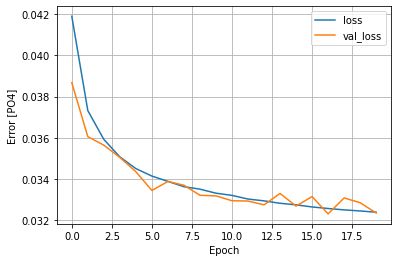

In [72]:
plot_loss(history) 

Collect the results on the test set:

In [75]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_target, verbose=0)

In [76]:
test_results

{'temp_model': 0.07481340318918228,
 'linear_model': 0.12832607328891754,
 'dnn_temp_model': 0.06714539229869843,
 'dnn_model': 0.03231717646121979}

## Performance

Now that all the models are trained check the test-set performance and see how they did:

In [77]:
pd.DataFrame(test_results, index=['Mean absolute error [PO4]']).T

,Mean absolute error [PO4]
temp_model,0.074813
linear_model,0.128326
dnn_temp_model,0.067145
dnn_model,0.032317


These results match the validation error seen during training.

### Make predictions

Finally, predict have a look at the errors made by the model when making predictions on the test set:

In [78]:
test_predictions = dnn_model.predict(test_features).flatten()

In [79]:
test_predictions.shape

(43333,)

In [81]:
test_target['SA PO4'].shape

(43333,)

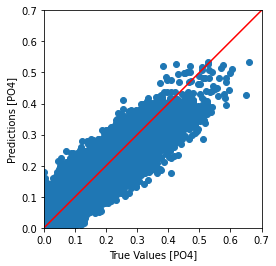

In [83]:
a = plt.axes(aspect='equal')
plt.scatter(test_target['SA PO4'], test_predictions)
plt.xlabel('True Values [PO4]')
plt.ylabel('Predictions [PO4]')
lims = [0, 0.7]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='red')

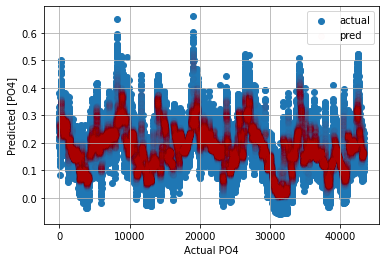

In [121]:
plt.scatter(np.arange(test_target['SA PO4'].shape[0]), test_target['SA PO4'], label='actual')
plt.scatter(np.arange(test_predictions.shape[0]), test_predictions, color='red', alpha=0.01, label='pred')
plt.xlabel('Actual PO4')
plt.ylabel('Predicted [PO4]')
plt.legend()
plt.grid(True)


It looks like the model predicts reasonably well. 

Now take a look at the error distribution:

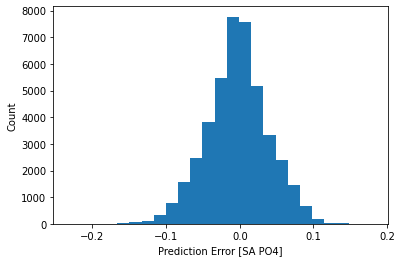

In [85]:
error = test_predictions - test_target['SA PO4']
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [SA PO4]')
_ = plt.ylabel('Count')

If you're happy with the model save it for later use:

In [89]:
dnn_model.save('dnn_model_mon_day_week')

INFO:tensorflow:Assets written to: dnn_model_mon_day_week/assets


If you reload the model, it gives identical output:

In [91]:
reloaded = tf.keras.models.load_model('dnn_model_mon_day_week')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_target, verbose=0)

In [92]:
pd.DataFrame(test_results, index=['Mean absolute error [PO4]']).T

,Mean absolute error [PO4]
temp_model,0.074813
linear_model,0.128326
dnn_temp_model,0.067145
dnn_model,0.032317
reloaded,0.032317


---
---

###  New section: load validation data and prepare.  Then predict using dnn model.  Plot actual vs predicted for PO4

### Data in validation905.xlsx

---
---

In [94]:
vdata = pd.read_excel("validation905.xlsx",na_values="NaN",  engine='openpyxl')

In [97]:
vdata.head()

,datetime,Year,Time,Month,DAY,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
0,2021-01-04 19:00:00,2021,19:00:00,1,4,1,2.386,7.3,8.39,679,51,11.7,12.5,0.13,0.16
1,2021-01-04 19:15:00,2021,19:15:00,1,4,1,2.138,7.3,8.38,680,54,11.7,12.5,0.13,0.16
2,2021-01-04 19:30:00,2021,19:30:00,1,4,1,2.026,7.3,8.38,681,56,11.7,12.5,0.13,0.16
3,2021-01-04 19:45:00,2021,19:45:00,1,4,1,2.149,7.3,8.38,681,58,11.7,12.6,0.13,0.16
4,2021-01-04 20:00:00,2021,20:00:00,1,4,1,2.370,7.3,8.38,680,58,11.7,12.5,0.14,0.16


In [98]:
vdata.describe()

,Year,Month,DAY,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
count,8344.0,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000
mean,2021.0,2.436242,14.659276,2.551414,4.036127,10.884827,8.107258,909.157718,68.657239,10.351498,13.043504,0.170541,0.101683
std,0.0,1.042204,8.267988,1.194294,1.377809,2.790385,0.131936,343.813260,56.250098,1.324320,3.072643,0.103846,0.043062
min,2021.0,1.000000,1.000000,1.000000,2.012000,4.600000,7.670000,510.000000,1.000000,5.200000,0.000000,0.000000,0.000000
25%,2021.0,2.000000,7.000000,1.000000,3.048750,9.500000,8.060000,578.000000,12.000000,9.900000,11.400000,0.100000,0.080000
50%,2021.0,2.000000,15.000000,3.000000,3.666500,10.700000,8.100000,855.000000,60.000000,10.600000,13.100000,0.150000,0.110000
75%,2021.0,3.000000,22.000000,4.000000,5.108250,12.300000,8.160000,1147.000000,109.000000,11.000000,15.200000,0.220000,0.120000
max,2021.0,4.000000,31.000000,5.000000,6.641000,16.900000,8.520000,1719.000000,283.000000,14.000000,18.600000,0.790000,0.270000


In [101]:
vdata['datetime'].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                    8344
unique                   8344
top       2021-03-25 10:45:00
freq                        1
first     2021-01-04 19:00:00
last      2021-04-26 22:00:00
Name: datetime, dtype: object

In [99]:
vdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8344 entries, 0 to 8343
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  8344 non-null   datetime64[ns]
 1   Year      8344 non-null   int64         
 2   Time      8344 non-null   object        
 3   Month     8344 non-null   int64         
 4   DAY       8344 non-null   int64         
 5   Week      8344 non-null   int64         
 6   GHI       8344 non-null   float64       
 7   TEMP      8344 non-null   float64       
 8   PH        8344 non-null   float64       
 9   EC        8344 non-null   int64         
 10  TURB      8344 non-null   int64         
 11  SA DO     8344 non-null   float64       
 12  SA NO3    8344 non-null   float64       
 13  SA NH4    8344 non-null   float64       
 14  SA PO4    8344 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(6), object(1)
memory usage: 977.9+ KB


In [102]:
data.isna().sum()

datetime    0
Year        0
Time        0
Month       0
Day         0
Week        0
GHI         0
TEMP        0
PH          0
EC          0
TURB        0
SA DO       0
SA NO3      0
SA NH4      0
SA PO4      0
dtype: int64

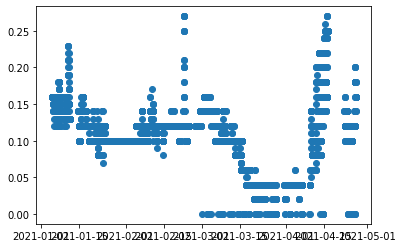

In [103]:
plt.scatter(vdata.datetime, vdata['SA PO4'])

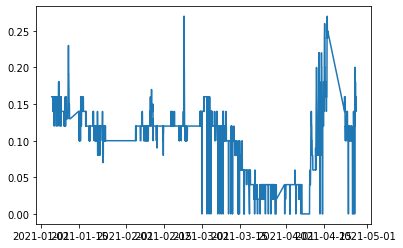

In [104]:
plt.plot(vdata.datetime, vdata['SA PO4'])

In [108]:
vpred = reloaded.predict(vdata[['Month', 'DAY', 'Week', 'GHI', 'TEMP', 'PH', 'EC', 'TURB']])

No handles with labels found to put in legend.


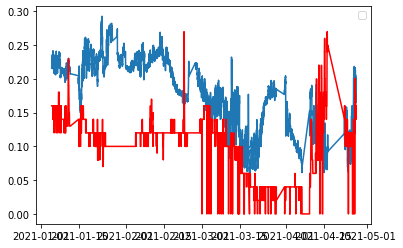

In [112]:
plt.plot(vdata.datetime, vpred,)
plt.plot(vdata.datetime, vdata['SA PO4'], color='red')


In [ ]:
plt.scatter()

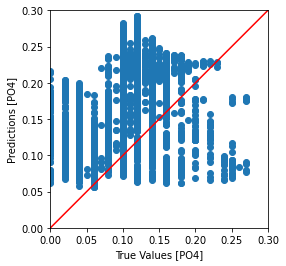

In [115]:
a = plt.axes(aspect='equal')
plt.scatter(vdata['SA PO4'], vpred)
plt.xlabel('True Values [PO4]')
plt.ylabel('Predictions [PO4]')
lims = [0, 0.3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='red')

array([[0.216],
       [0.22 ],
       [0.221],
       [0.219],
       [0.216],
       [0.217],
       [0.225],
       [0.225],
       [0.225],
       [0.226],
       [0.224],
       [0.225],
       [0.219],
       [0.223],
       [0.225],
       [0.216],
       [0.218],
       [0.221],
       [0.226],
       [0.217],
       [0.23 ],
       [0.22 ],
       [0.226],
       [0.232],
       [0.236]], dtype=float32)